In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

def load_embeddings(file_path):
    return torch.load(file_path).cpu().numpy()

In [2]:
train_embeddings = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/train_embeddings.pth')
test_embeddings = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/test_embeddings.pth')
train_labels = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/train_labels.pth')
test_labels = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/test_labels.pth')

In [3]:
def get_hash(vec, planes):
    dot_product = np.dot(vec, planes.T)
    return ''.join(map(str, (dot_product > 0).astype(int)))

In [4]:
nbits = 5
d = train_embeddings.shape[1]
k = 100
plane_norms = np.random.rand(nbits, d)
buckets = {}
for idx, train_data_point in enumerate(train_embeddings):
    hash_str = get_hash(train_data_point, plane_norms)
    if hash_str not in buckets:
        buckets[hash_str] = []
    buckets[hash_str].append(idx)

In [5]:
def mean_reciprocal_rank(nearest_neighbors, train_labels, test_labels):
    mrr = 0.0
    for i in range(len(nearest_neighbors)):
        true_label = test_labels[i]

        neighbors = nearest_neighbors[i]

        for rank, neighbor_idx in enumerate(neighbors):
            if train_labels[neighbor_idx] == true_label:
                mrr += 1 / (rank + 1)
                break
        
    return mrr / len(nearest_neighbors)


def precision_at_k(nearest_neighbors, train_labels, test_labels, k=100):
    precision = 0.0
    for i in range(len(nearest_neighbors)):
        true_label = test_labels[i] 
        neighbors = nearest_neighbors[i]

        relevant_count = 0
        for neighbor_idx in neighbors[:k]:
            if train_labels[neighbor_idx] == true_label:
                relevant_count += 1
        precision += relevant_count / k
        
    return precision / len(nearest_neighbors)

def hit_rate_at_k(nearest_neighbors, train_labels, test_labels,k=100):
    hits = 0
    for i in range(len(nearest_neighbors)):
        true_label = test_labels[i] 
        neighbors = nearest_neighbors[i]

        if any(train_labels[neighbor_idx] == true_label for neighbor_idx in neighbors[:k]):
            hits += 1
        
    return hits / len(nearest_neighbors)

In [6]:

def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

In [7]:
def find_nearest_neighbors(test_data_point):
    hash_str = get_hash(test_data_point, plane_norms)
    
    sorted_buckets = sorted(buckets.keys())
    
    if hash_str in sorted_buckets:
        start_idx = sorted_buckets.index(hash_str)
    else:
        start_idx = 0

    nearest_neighbors = []
    comparisons = 0

    for i in range(start_idx, len(sorted_buckets)):
        bucket_key = sorted_buckets[i]
        candidates = buckets[bucket_key]
        
        nearest_neighbors.extend(candidates)
        comparisons += len(candidates)

        if len(nearest_neighbors) >= k:
            return nearest_neighbors[:k], comparisons

    return nearest_neighbors, comparisons


In [8]:
nearest_neighbours = []
total_comparisons = 0
for test_data_point in test_embeddings:
    neighbors, comparisons = find_nearest_neighbors(test_data_point)
    nearest_neighbours.append(neighbors)
    total_comparisons += comparisons

mrr = mean_reciprocal_rank(nearest_neighbours, train_labels, test_labels)
print(f"MRR: {mrr}")
precision = precision_at_k(nearest_neighbours, train_labels, test_labels, k)
hit_rate = hit_rate_at_k(nearest_neighbours, train_labels, test_labels, k)

print(f"Precision@100: {precision}")
print(f"Hit Rate@100: {hit_rate}")


MRR: 0.3329733313110391
Precision@100: 0.1499859999999951
Hit Rate@100: 0.9964


In [9]:
print(total_comparisons/len(test_embeddings))

12774.6778


In [10]:
def average_comparisons(test_embeddings, buckets, plane_norms):
    total_comparisons = 0

    for test_data_point in test_embeddings:
        hash_str = get_hash(test_data_point, plane_norms)
        
        comparisons_for_query = len(buckets.get(hash_str, []))

        additional_comparisons = 0

        for other_hash, candidates in buckets.items():
            if other_hash != hash_str:
                additional_comparisons += len(candidates)
                if comparisons_for_query + additional_comparisons >= k:
                    break

        total_comparisons += comparisons_for_query + additional_comparisons

    avg_comparisons = total_comparisons / len(test_embeddings)
    return avg_comparisons

avg_comparisons_value = average_comparisons(test_embeddings, buckets, plane_norms)
print(f"Average number of comparisons per query: {avg_comparisons_value}")


Average number of comparisons per query: 25098.4631


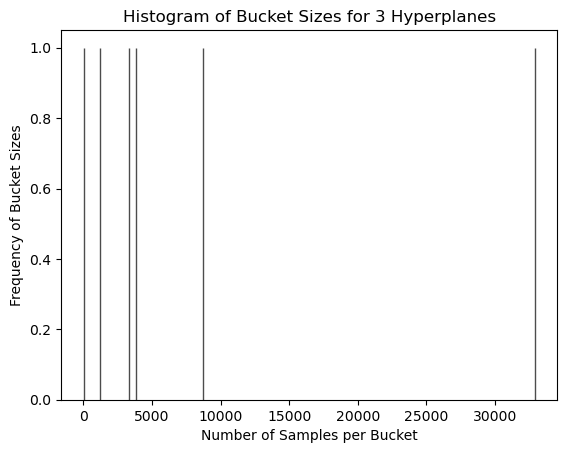

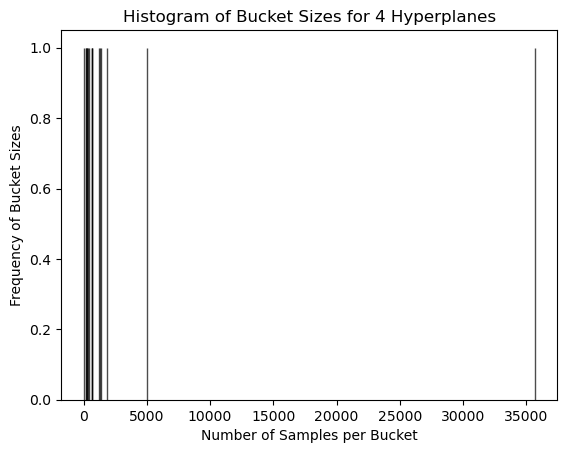

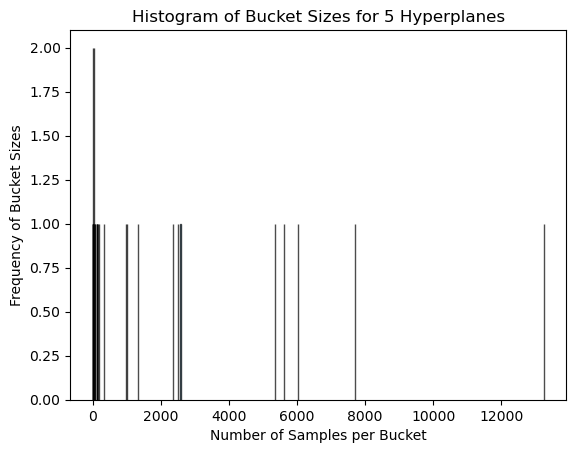

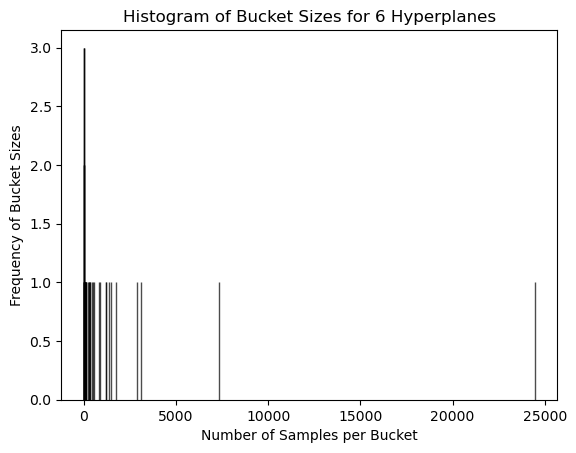

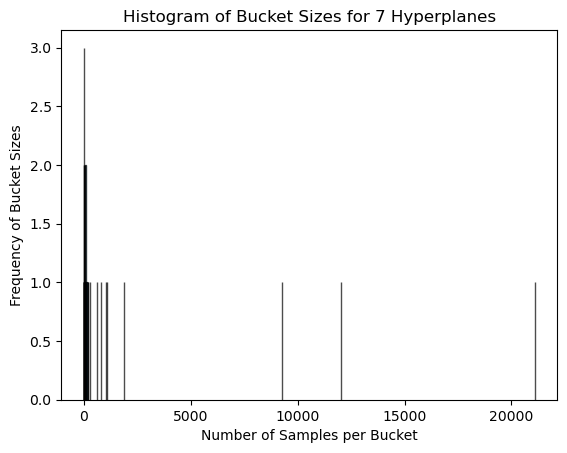

In [5]:
import numpy as np
import matplotlib.pyplot as plt

nbits = [3, 4, 5, 6, 7]
for nbit in nbits:
    d = train_embeddings.shape[1]
    k = 100
    plane_norms = np.random.rand(nbit, d)  # Note the change from nbits to nbit
    buckets = {}
    
    # Hashing and bucketing
    for idx, train_data_point in enumerate(train_embeddings):
        hash_str = get_hash(train_data_point, plane_norms)
        if hash_str not in buckets:
            buckets[hash_str] = []
        buckets[hash_str].append(idx)
    
    # Calculate bucket sizes (number of samples in each bucket)
    bucket_sizes = [len(indices) for indices in buckets.values()]

    # Count how many buckets have a particular number of samples (frequency of bucket sizes)
    bucket_size_counts = {}
    for size in bucket_sizes:
        if size not in bucket_size_counts:
            bucket_size_counts[size] = 0
        bucket_size_counts[size] += 1
    
    # Plot histogram of bucket size frequencies
    plt.bar(bucket_size_counts.keys(), bucket_size_counts.values(), edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of Bucket Sizes for {nbit} Hyperplanes")
    plt.xlabel('Number of Samples per Bucket')
    plt.ylabel('Frequency of Bucket Sizes')
    plt.show()
